# Part1   

In [52]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

Read data

In [3]:
df=pd.read_csv('train1.csv')

Kiểm tra các giá trị null

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Kiểm tra các giá trị bằng 0

In [5]:
print('Insulin: ',df['Insulin'].isin([0]).sum())
print('Pregnancies: ',df['Pregnancies'].isin([0]).sum())
print('Glucose: ',df['Glucose'].isin([0]).sum())
print('BloodPressure: ',df['BloodPressure'].isin([0]).sum())
print('SkinThickness: ',df['SkinThickness'].isin([0]).sum())
print('BMI: ',df['BMI'].isin([0]).sum())
print('DiabetesPedigreeFunction: ',df['DiabetesPedigreeFunction'].isin([0]).sum())
print('Age: ',df['Age'].isin([0]).sum())


Insulin:  263
Pregnancies:  77
Glucose:  4
BloodPressure:  26
SkinThickness:  154
BMI:  9
DiabetesPedigreeFunction:  0
Age:  0


Xử lý các giá trị 0 bằng median

In [6]:
data=df

In [7]:
df=df.drop('Outcome', axis=1)

In [8]:
for col in df.columns:
    median = df[col].median()
    df[col] = df[col].apply(lambda x: median if x==0 else x)

In [9]:
df=df.assign(Outcome=data['Outcome'])

In 5 dòng đầu và các cột

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4.0,137.0,84.0,22.5,24.0,31.2,0.252,30,0
1,6.0,195.0,70.0,22.5,24.0,30.9,0.328,31,1
2,8.0,120.0,72.0,22.5,24.0,30.0,0.183,38,1
3,3.0,104.0,64.0,23.0,116.0,27.8,0.454,23,0
4,1.0,125.0,70.0,24.0,110.0,24.3,0.221,25,0


In [11]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Kiểm tra outliers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


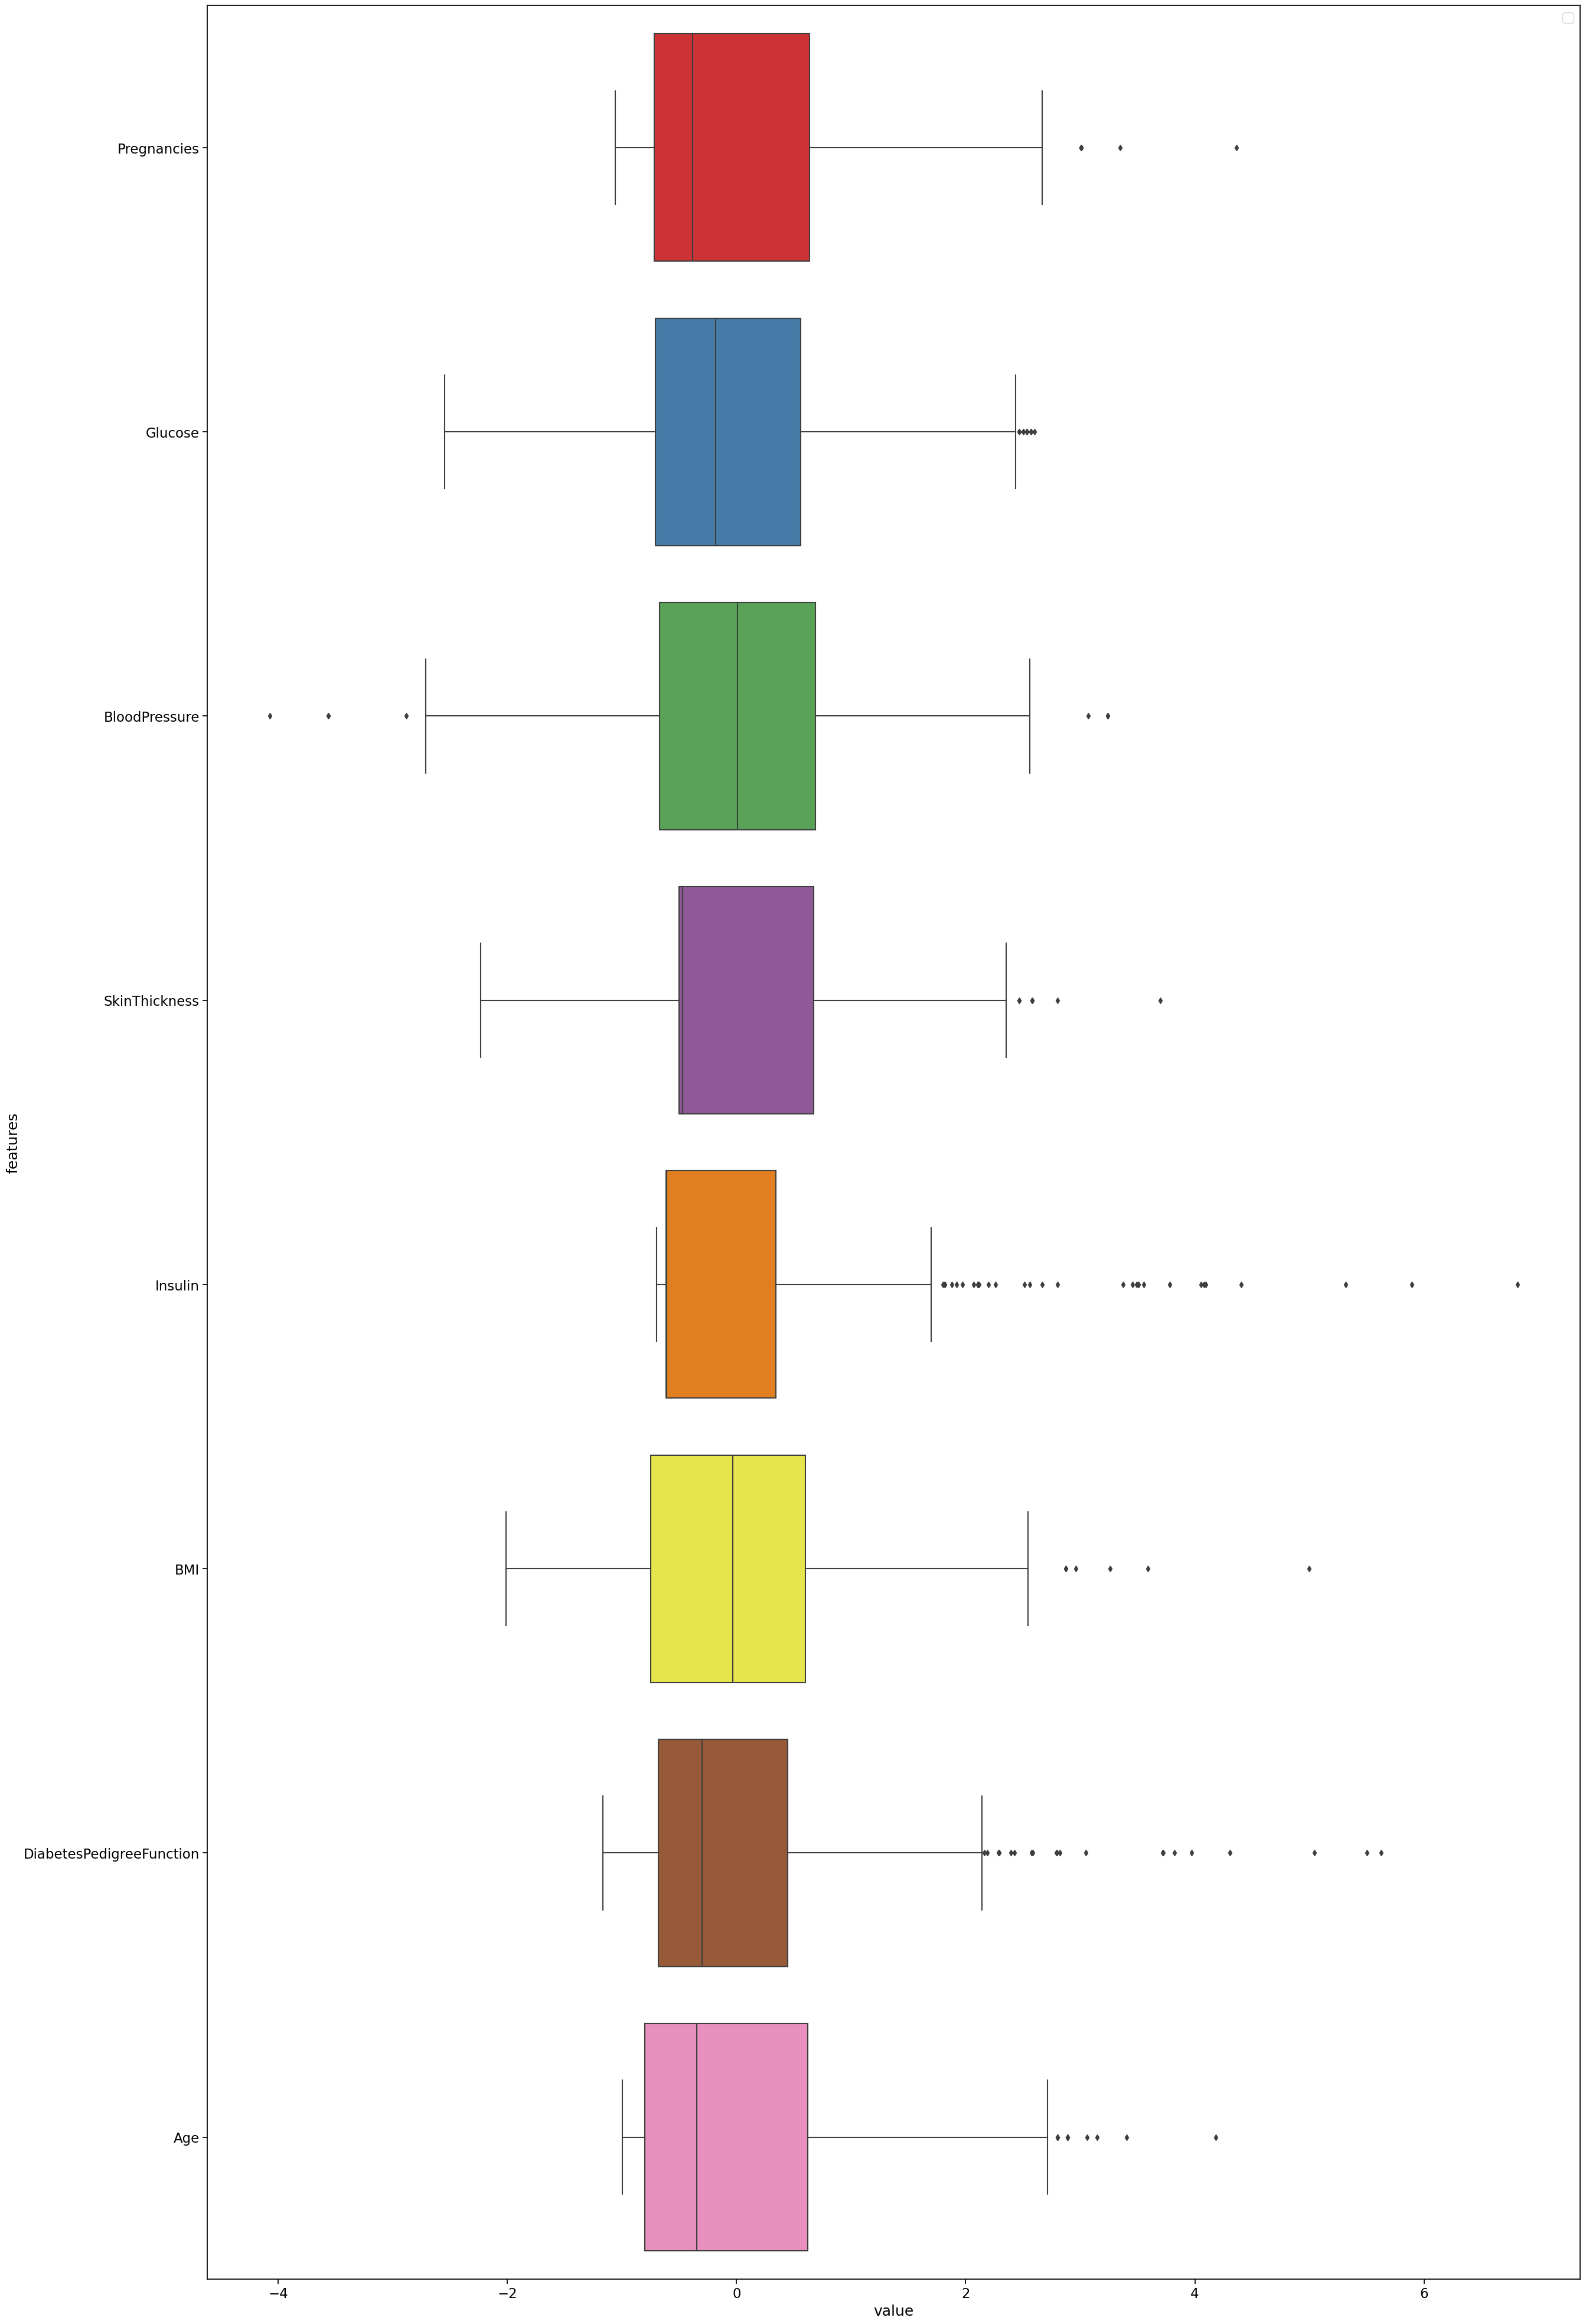

In [12]:
features=df.drop('Outcome',axis=1)
y=df.Outcome
# Standardization of features
stdX = (features - features.mean()) / (features.std())              
data_st = pd.concat([y,stdX.iloc[:,:]],axis=1)
data_st = pd.melt(data_st,id_vars="Outcome",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,50))
sns.set_context('notebook', font_scale=1.5)
sns.boxplot(x="value", y="features", data=data_st, palette='Set1')
plt.legend(loc='best')

Xử lý outliers

In [13]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

In [14]:
for i in features:
    df[i]= BoxplotOutlierClipper().fit_transform(df[i])

# PART2 

Gán feature bằng các cột trong data trừ cột Outcome

In [15]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [16]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,4.100372,120.172862,71.959108,26.931691,83.591078,32.179043,0.450549,32.464684
std,2.867197,29.788701,11.439021,8.834020,80.848780,6.763442,0.280806,11.365055
min,1.000000,44.000000,40.000000,7.000000,15.000000,18.200000,0.078000,21.000000
25%,2.000000,99.000000,64.000000,22.500000,24.000000,27.025000,0.238000,23.250000
50%,3.000000,114.750000,72.000000,22.750000,24.500000,32.000000,0.365500,28.500000
75%,6.000000,137.000000,80.000000,33.000000,130.000000,36.450000,0.612750,39.750000
max,12.000000,194.000000,104.000000,48.750000,289.000000,50.587500,1.174875,64.500000


Tính phần trăm tỉ lệ xuất hiện của các giá trị 0,1

In [17]:
y.value_counts(normalize=True)

Outcome
0          0.715613
1          0.284387
dtype: float64

<AxesSubplot: xlabel='Outcome'>

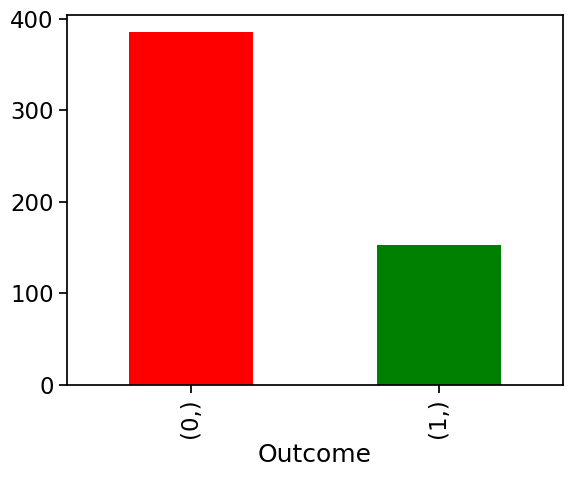

In [18]:
y.value_counts().plot.bar(color=['red', 'green'])

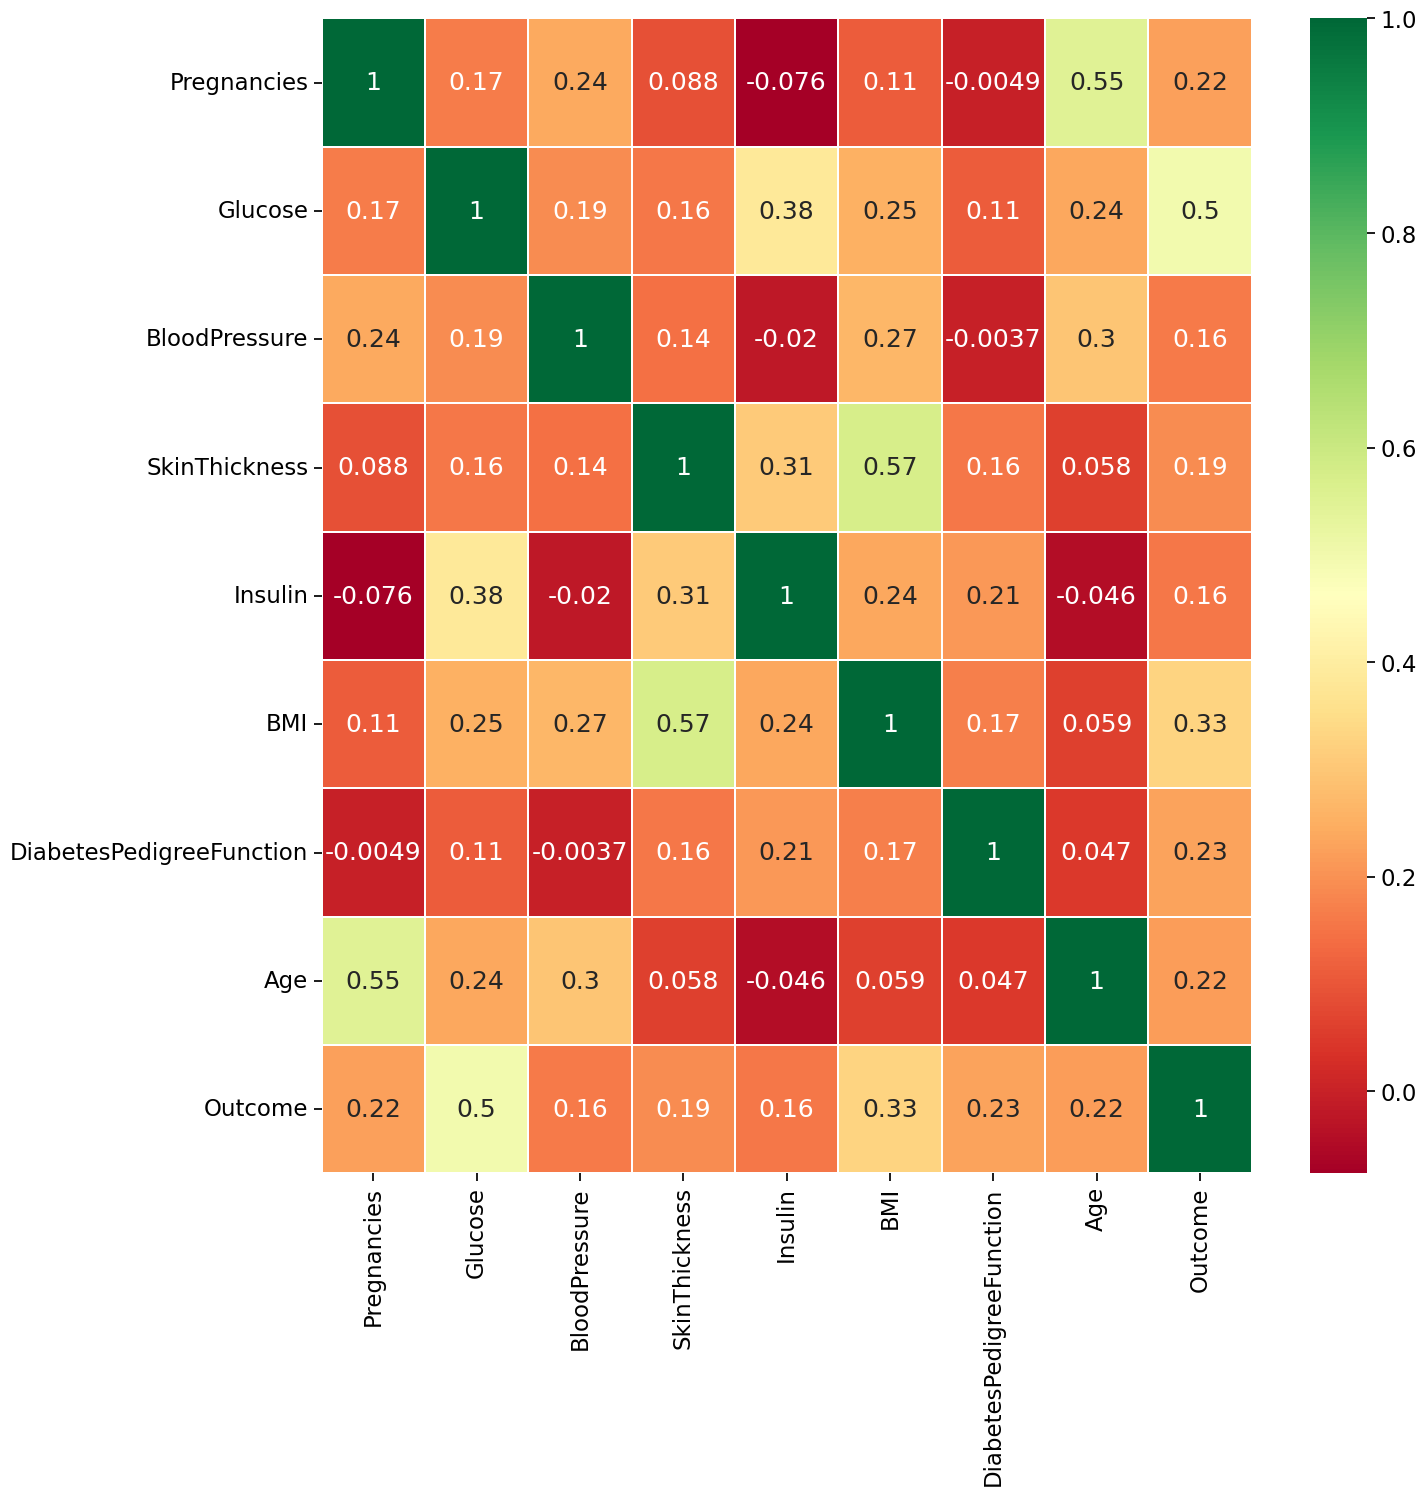

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),linewidths=0.30,cmap ='RdYlGn',annot=True)
plt.show()

In [20]:
y = (df['Outcome']).astype(int)
fields = list(df.columns[:-1])  # everything except "color"
correlations = df[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations

Insulin                     0.155558
BloodPressure               0.161609
SkinThickness               0.190215
Age                         0.220774
Pregnancies                 0.223872
DiabetesPedigreeFunction    0.226826
BMI                         0.329062
Glucose                     0.495708
dtype: float64

# Part3 chia data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 123)

Tạo hàm đánh giá mô hình

In [22]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

# PART4: KNN

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=7)

Khởi chạy model với n_neighbors=7

In [24]:
knn_model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=7)

In [25]:
preds = knn_model.predict(X_test)

In [26]:
acc_knn=evaluate_metrics(y_test, preds)

gán giá trị accuracy để tiện việc so sánh 3 model

Tìm K tốt nhất

In [27]:
# Try K from 1 to 50
max_k = 50
# Create an empty list to store f1score for each k
f1_scores = []

In [28]:
for k in range(1, max_k + 1):
    # Create a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the classifier
    knn = knn.fit(X_train, y_train.values.ravel())
    preds = knn.predict(X_test)
    # Evaluate the classifier with f1score
    f1 = f1_score(preds, y_test)
    f1_scores.append((k, round(f1_score(y_test, preds), 4)))
# Convert the f1score list to a dataframe
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
f1_results.set_index('K')

,F1 Score
K,
1,0.4839
2,0.4783
3,0.6071
4,0.5882
5,0.6071
6,0.5882
7,0.6182
8,0.6000
9,0.6182


Text(0.5, 1.0, 'KNN F1 Score')

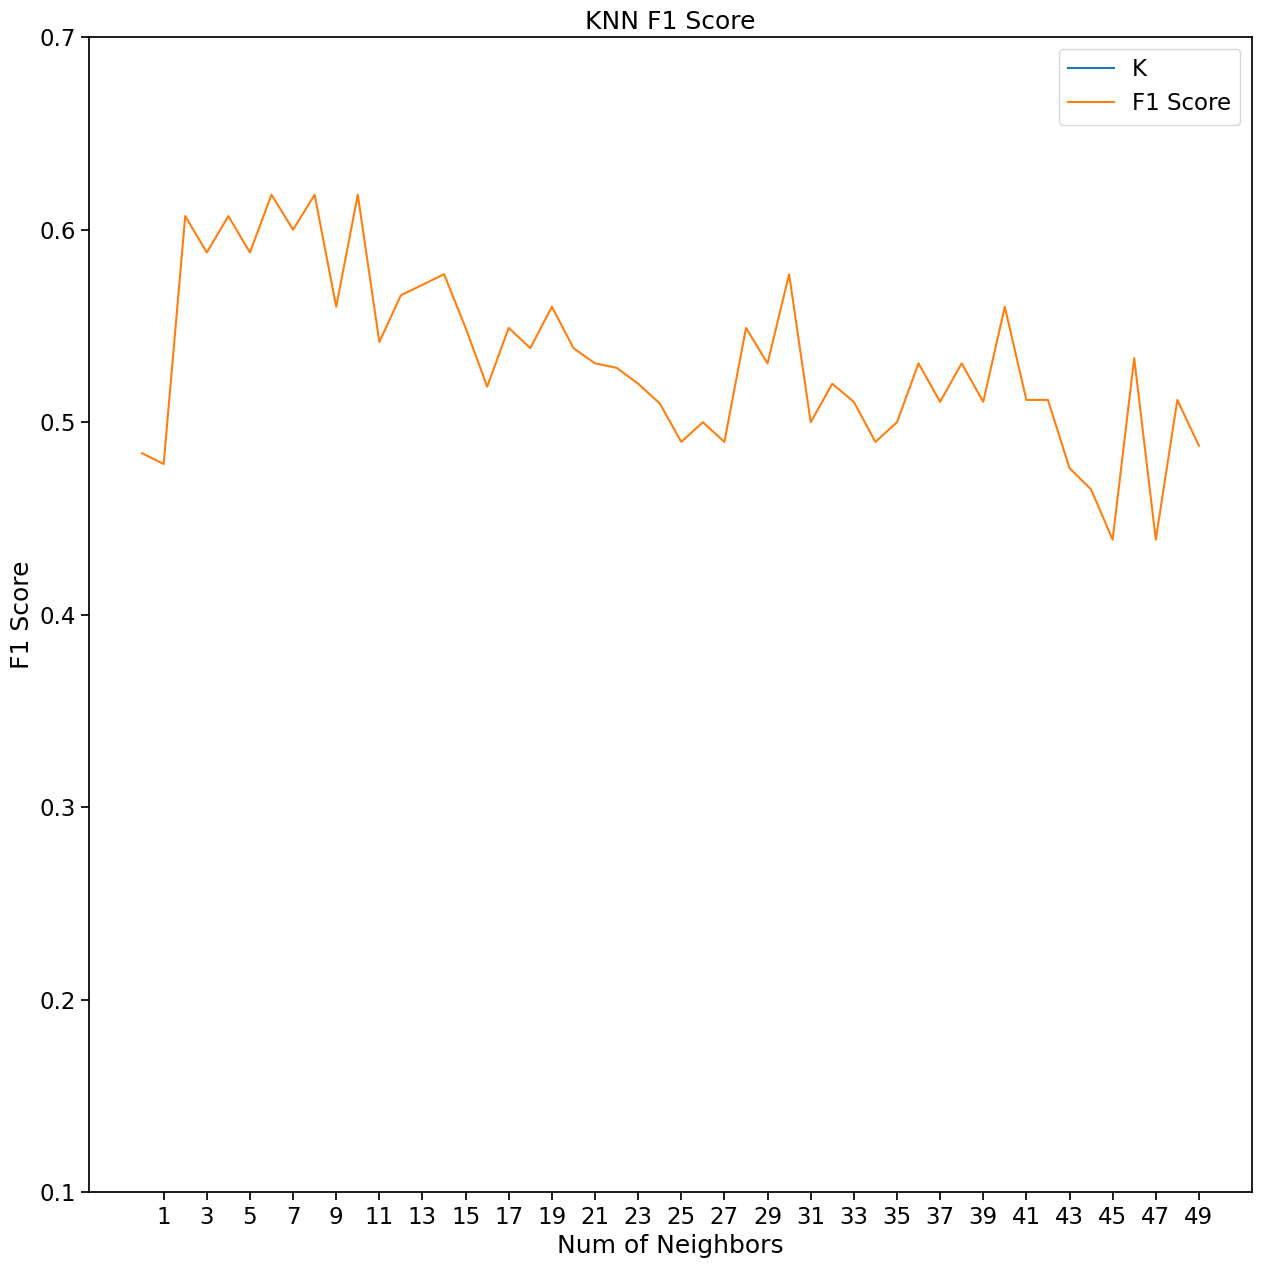

In [29]:
# Plot F1 results
ax = f1_results.plot(figsize=(15,15))
ax.set(xlabel='Num of Neighbors', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.ylim((0.1, 0.7))
plt.title('KNN F1 Score')

# PART5 : SVM

In [30]:
params_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

In [31]:
model = SVC()

Dùng thư viện GridSearchCV để tìm ra thông số tổt nhất

In [32]:
# Define a GridSearchCV to search the best parameters
grid_search = GridSearchCV(estimator = model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 3)
# Search the best parameters with training data
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

In [40]:
best_params

{'C': 100, 'kernel': 'poly'}

Khởi chạy model với các thông số tốt nhất

In [46]:
svm = SVC(C=100, kernel='poly')
svm.fit(X_train, y_train.values.ravel())
preds = svm.predict(X_test)
acc_svm=evaluate_metrics(y_test, preds)

# PART6: RANDOM FOREST

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
model = RandomForestClassifier()
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [67]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

In [68]:
model = RandomForestClassifier()

Dùng thư viện GridsearchCV để tìm ra các thông số tốt nhất cho model

In [90]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='f1',cv=3)
search.fit(X_train, y_train)

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ngois\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='f1')

In ra các giá trị tốt nhất

In [88]:
search.best_params_

{'max_depth': 13, 'max_features': 'log2', 'n_estimators': 21}

Chạy model với thông số tốt nhất

In [89]:
rf = RandomForestClassifier(max_depth=13, max_features='log2', n_estimators=21)
rf = rf.fit(X_train, y_train.values.ravel())

preds = rf.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.8148148148148148,
 'recall': 0.5161290322580645,
 'precision': 0.7619047619047619,
 'f1score': 0.6153846153846153}

In [91]:
acc_rf=evaluate_metrics(y_test, preds)

# PART7 : Compare 3 algorithm - Build confusion matrix

In [43]:
acc_knn

{'accuracy': 0.8055555555555556,
 'recall': 0.5483870967741935,
 'precision': 0.7083333333333334,
 'f1score': 0.6181818181818182}

In [47]:
acc_svm

{'accuracy': 0.8055555555555556,
 'recall': 0.5161290322580645,
 'precision': 0.7272727272727273,
 'f1score': 0.6037735849056604}

In [92]:
acc_rf

{'accuracy': 0.8148148148148148,
 'recall': 0.5161290322580645,
 'precision': 0.7619047619047619,
 'f1score': 0.6153846153846153}

Create confusion matrix

In [56]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train.values.ravel())
preds = knn_model.predict(X_test)
cm_knn = confusion_matrix(y_test, preds)

In [57]:
model = SVC()
svm = SVC(C=100, kernel='poly')
svm.fit(X_train, y_train.values.ravel())
preds = svm.predict(X_test)
cm_svm = confusion_matrix(y_test, preds)

In [62]:
rf = RandomForestClassifier(max_depth=11, max_features='log2', n_estimators=13)
rf = rf.fit(X_train, y_train.values.ravel())
preds = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)

In [59]:
cm_knn

array([[68,  9],
       [14, 17]], dtype=int64)

FN=14

In [60]:
cm_svm

array([[71,  6],
       [15, 16]], dtype=int64)

FN=15

In [63]:
cm_rf

array([[65, 12],
       [12, 19]], dtype=int64)

FN=12

# PART8: Prediction

Trong PART 7 chúng ta đã có thể chọn ra model tốt nhất đó là Random Forest

In [57]:
df_test=pd.read_csv('test11 (1).csv')

In [58]:
print('Insulin: ',df_test['Insulin'].isin([0]).sum())
print('Pregnancies: ',df_test['Pregnancies'].isin([0]).sum())
print('Glucose: ',df_test['Glucose'].isin([0]).sum())
print('BloodPressure: ',df_test['BloodPressure'].isin([0]).sum())
print('SkinThickness: ',df_test['SkinThickness'].isin([0]).sum())
print('BMI: ',df_test['BMI'].isin([0]).sum())
print('DiabetesPedigreeFunction: ',df_test['DiabetesPedigreeFunction'].isin([0]).sum())
print('Age: ',df_test['Age'].isin([0]).sum())


Insulin:  111
Pregnancies:  34
Glucose:  1
BloodPressure:  9
SkinThickness:  73
BMI:  2
DiabetesPedigreeFunction:  0
Age:  0


In [59]:
for col in df_test.columns[:-2]:
    median = df_test[col].median()
    df_test[col] = df_test[col].apply(lambda x: median if x==0 else x)

In [60]:
df_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4.0,114.0,65.0,23.5,40.5,21.9,0.432,37
1,3.0,146.0,70.0,23.5,40.5,37.9,0.334,28
2,3.0,111.0,65.0,23.5,40.5,24.6,0.660,31
3,3.0,158.0,70.0,30.0,328.0,35.5,0.344,35
4,2.0,197.0,70.0,99.0,40.5,34.7,0.575,62


In [61]:
y_pred = rf.predict(df_test)

In [62]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1])

In [63]:
df_test = pd.concat([df_test, pd.DataFrame({'Outcome': y_pred})], axis=1)

In [64]:
df_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4.0,114.0,65.0,23.5,40.5,21.9,0.432,37,0
1,3.0,146.0,70.0,23.5,40.5,37.9,0.334,28,0
2,3.0,111.0,65.0,23.5,40.5,24.6,0.660,31,0
3,3.0,158.0,70.0,30.0,328.0,35.5,0.344,35,0
4,2.0,197.0,70.0,99.0,40.5,34.7,0.575,62,1


<AxesSubplot: xlabel='Outcome'>

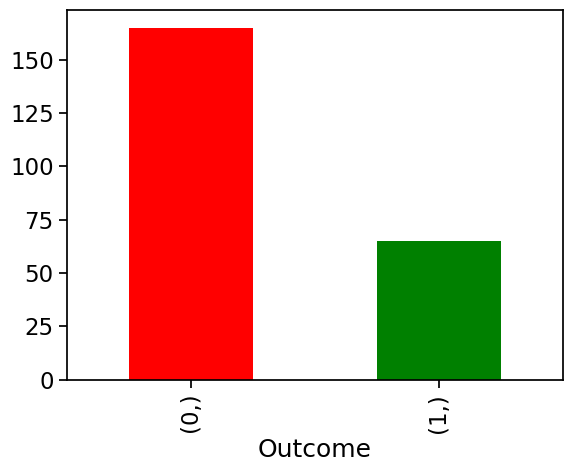

In [65]:
y = df_test.iloc[:, -1:]
y.value_counts(normalize=True)
y.value_counts().plot.bar(color=['red', 'green'])

In [66]:
y.value_counts(normalize=True)

Outcome
0          0.717391
1          0.282609
dtype: float64